# 可解释的AI(eXplainable AI, XAI)

## 载入套件

In [ ]:
!pip install torchsummary

In [1]:
import torch
from torchvision import models
from torch import nn
import numpy as np
from torchsummary import summary

## 检查 GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 使用预先训练的模型

In [3]:
rn18 = models.resnet18(pretrained=True)

## 显示神经层名称

In [4]:
children_counter = 0
for n,c in rn18.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


## 显示神经层明细

In [5]:
rn18._modules

OrderedDict([('conv1',
              Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
             ('bn1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('relu', ReLU(inplace=True)),
             ('maxpool',
              MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
             ('layer1',
              Sequential(
                (0): BasicBlock(
                  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (relu): ReLU(inplace=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (1): BasicBlock(
         

In [8]:
from torchsummary import summary

summary(rn18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 移除 layer1 后面的神经层

In [9]:
class new_model(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = models.resnet18(pretrained=True)
        self.children_list = []
        # 依序取得每一层
        for n,c in self.pretrained.named_children():
            self.children_list.append(c)
            # 找到特定层即终止
            if n == self.output_layer:
                print('found !!')
                break

        # 建构新模型
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x
    
model = new_model(output_layer = 'layer1')
model = model.to(device)    

found !!


In [10]:
from torchsummary import summary

summary(model,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

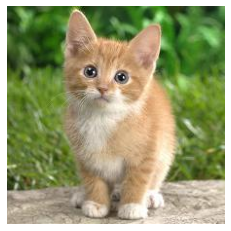

torch.Size([1, 512, 7, 7])

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

img = Image.open("./images_test/cat.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

resize = transforms.Resize([224, 224])
img = resize(img)

to_tensor = transforms.ToTensor()
img = to_tensor(img).to(device)
img = img.reshape(1, *img.shape)
out = model(img)
out.shape

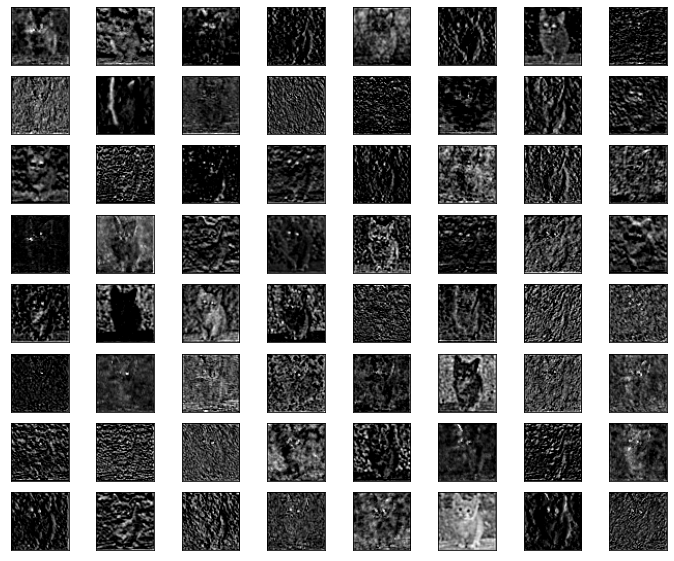

In [12]:
# 重建 8x8 图像
def show_grid(out):
    square = 8
    plt.figure(figsize=(12, 10))
    for fmap in out.cpu().detach().numpy():
        # plot all 64 maps in an 8x8 squares
        ix = 1
        for _ in range(square):
            for _ in range(square):
                # specify subplot and turn of axis
                ax = plt.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[ix-1, :, :], cmap='gray')
                ix += 1
        # show the figure
        plt.show()
        
show_grid(out)

found !!


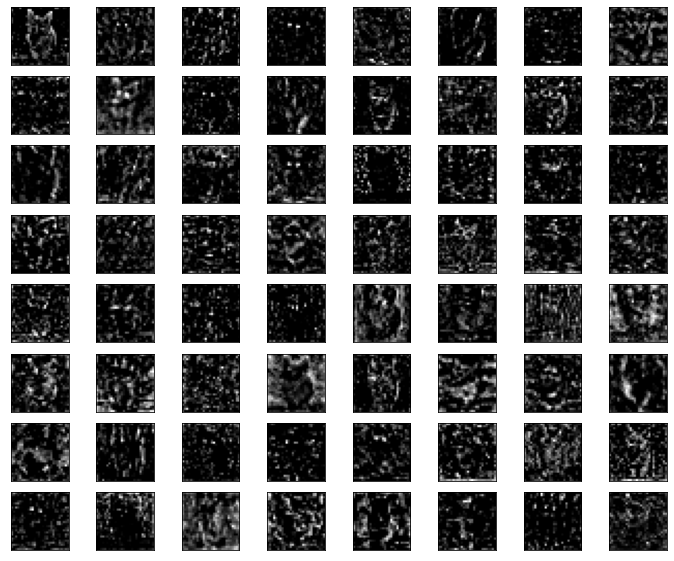

In [13]:
model = new_model(output_layer = 'layer2').to(device)
out = model(img)
show_grid(out)

found !!


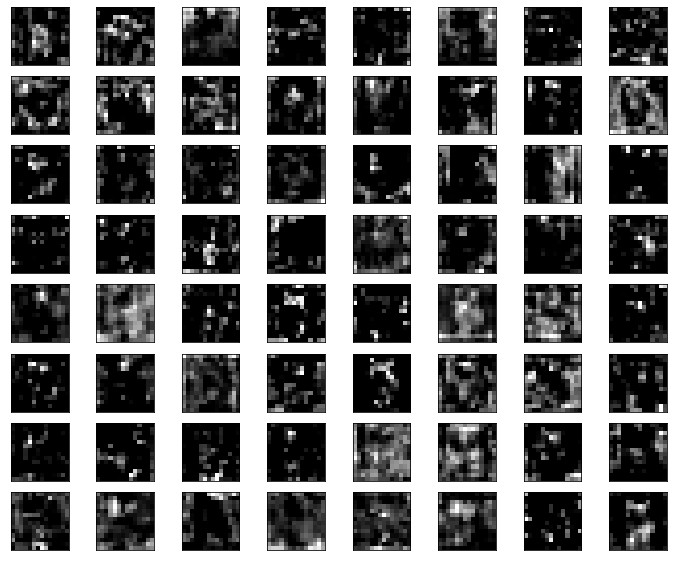

In [14]:
model = new_model(output_layer = 'layer3').to(device)
out = model(img)
show_grid(out)

found !!


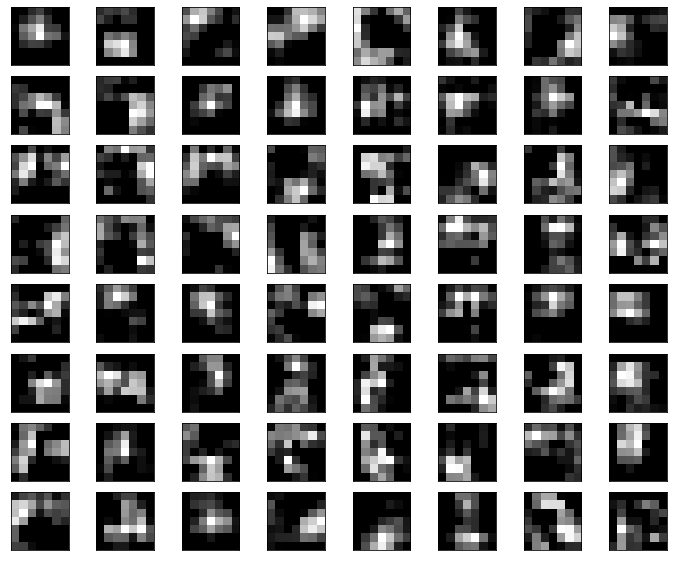

In [15]:
model = new_model(output_layer = 'layer4').to(device)
out = model(img)
show_grid(out)